**Imports and includes**

In [1]:
import csv
import numpy as np 
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt 
import pickle
import statistics
import numpy as np  
import sys
import glob

pd.set_option('display.max_rows', 4000)
pd.set_option('display.max_columns', 200)

In [2]:
from langdetect import detect
from langdetect import DetectorFactory
DetectorFactory.seed = 0

In [3]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()

**Sentiment analysis function provided by Upasana**

In [4]:
def sentiment_analyzer_score_for_englishOnlyTweet(cleaned_tweet): #this function takes in a tweet that has been detected as an english tweet
    score = analyser.polarity_scores(cleaned_tweet) #so this cleaned_tweet is always an english tweet.
    lb = score['compound']
    return lb

**Create list of all Baseline Users**

In [5]:
all_user_lists=[
    "/home/updu6059/Twint_Data/ParallelProcessing/Famous_Users/DidNotMentionBack_Users/Filtered_EnglishUsers_DidNotMentionedBackUsers_FINAL.csv",
    "/home/updu6059/Twint_Data/ParallelProcessing/Famous_Users/MentionedBack_Users/Filtered_EnglishUsers_MentionedBackUsers_FINAL.csv"]

UserList = []
userPathDict = {}
for i in range(2):  
    df = pd.read_csv(all_user_lists[i])
    tempUserList = list(df['Users'])
    for j in range(len(tempUserList)):
        UserList.append(tempUserList[j])
        if (i == 0) : userPathDict[tempUserList[j]] = '/home/updu6059/Twint_Data/ParallelProcessing/Famous_Users/User_Data/English_Only_Tweets/'
        elif (i == 1) : userPathDict[tempUserList[j]] = '/home/updu6059/Twint_Data/ParallelProcessing/Famous_Users/User_Data/English_Only_Tweets/'
#         elif (i == 2) : userPathDict[tempUserList[j]] = '/home/updu6059/Twint_Data/ParallelProcessing/OnlyEnglishTweets/'
#         elif (i == 3) : userPathDict[tempUserList[j]] = '/home/updu6059/Twint_Data/ParallelProcessing/OnlyEnglishTweets/'
    

In [6]:
print("Number of possibly affected users: " + str(len(UserList)))

Number of possibly affected users: 3414


In [7]:
# with open('pau_all.txt', 'w') as filehandle:
#     for listitem in UserList:
#         filehandle.write('%s\n' % listitem)

**Functions to check for a mention of Donald Trump or Hillary Clinton in a tweet**

In [8]:
def mentions_trump(mention_string):
    if mention_string != "[]": 
        mention_list = mention_string.split(', ')
        mention_list[0] = mention_list[0][1:]
        mention_list[-1] = mention_list[-1][:-1]
        for x in range(len(mention_list)):
            mention_list[x] = mention_list[x][1:]
            mention_list[x] = mention_list[x][:-1]
        for x in range(len(mention_list)):
            if mention_list[x] == 'realdonaldtrump':
                return True
    return False

In [9]:
def mentions_clinton(mention_string):
    if mention_string != "[]": 
        mention_list = mention_string.split(', ')
        mention_list[0] = mention_list[0][1:]
        mention_list[-1] = mention_list[-1][:-1]
        for x in range(len(mention_list)):
            mention_list[x] = mention_list[x][1:]
            mention_list[x] = mention_list[x][:-1]
        for x in range(len(mention_list)):
            if mention_list[x] == 'hillaryclinton':
                return True
    return False

**Calculate monthy values for each user (over the 96 months from Jan 2009 to December 2016)**

In [10]:
timelineDict = {}

In [11]:
firstTweetIndexDict = {}

In [12]:
timelineDF = pd.DataFrame(columns=['username','tweet_count','sentiment_scores', 
                                      'trump_count', 'clinton_count','trump_sent','clinton_sent',
                                      'positive_sent', 'negative_sent'])

In [13]:
size = str(len(UserList))
for i in range(len(UserList)):
# for i in range(100):
    try:
        #read in, reverse order (so oldest is first), reset index
        temp_user_db = pd.read_csv(userPathDict[UserList[i]]+UserList[i]+'.csv', header=None, low_memory=False)
        temp_user_db = temp_user_db.iloc[::-1]
        temp_user_db.reset_index(drop=True, inplace=True)

        #create lists for each metric
        tweet_count = [
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0]
        trump_count = [
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0]
        clinton_count = [
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0,
            0,0,0,0,0,0,0,0,0,0,0,0]
        sentiment_scores = [
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[]]
        trump_sent = [
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[]]
        clinton_sent = [
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[]]
        positive_sent = [
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[]]
        negative_sent = [
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[],
            [],[],[],[],[],[],[],[],[],[],[],[]]

        #iterate through user tweets
        first = 1
        for j in range(len(temp_user_db)):

            #step one is assigning an index for the tweet, based on date, or disregarding
            found = 0
            tweetdate = dt.strptime(temp_user_db[3][j], "%Y-%m-%d")
            for k in range(2009,2017):
                temp_year = k
                date_start = dt(temp_year,1,1)
                date_end = dt(temp_year,12,31)
                if tweetdate < date_start:
                    continue;
                elif tweetdate <= date_end:
                    for m in range(2,14):
                        if m == 13: #month must be December by process of elimination
                            use_index = (((k-2009)*12)+(m-2))
                            found = 1
    #                         print(temp_user_db['date'][j] + " " +str(use_index))
                            break;
                        next_month_start = dt(temp_year,m,1)
                        if tweetdate < next_month_start:
                            use_index = (((k-2009)*12)+(m-2))
                            found = 1
    #                         print(temp_user_db['date'][j] + " " +str(use_index))
                            break;

            #tweet occurred within the period 2009-2016 and was assigned an valid index
            if found == 1:
                if first:
                    firstTweetIndexDict[UserList[i]] = use_index
                    first = 0

                tweet_count[use_index] +=1

                tweet_sent = sentiment_analyzer_score_for_englishOnlyTweet(temp_user_db[10][j])
                sentiment_scores[use_index].append(tweet_sent)

                trump_flag = mentions_trump(str(temp_user_db[11][j]))
                clinton_flag = mentions_clinton(str(temp_user_db[11][j]))

                if trump_flag: trump_count[use_index] += 1
                if clinton_flag: clinton_count[use_index] += 1

                if trump_flag and not clinton_flag: trump_sent[use_index].append(tweet_sent)
                if clinton_flag and not trump_flag: clinton_sent[use_index].append(tweet_sent)

                if tweet_sent > 0: positive_sent[use_index].append(tweet_sent)
                if tweet_sent < 0: negative_sent[use_index].append(tweet_sent)

        timelineDict[UserList[i]] = [tweet_count, sentiment_scores, trump_count, clinton_count, 
                                     trump_sent, clinton_sent, positive_sent, negative_sent]

        print(str(i) + " / " + size)

    except Exception as e: 
        print(str(UserList[i]) + " failed - " + str(e))

        

0 / 3414
1 / 3414
2 / 3414
3 / 3414
4 / 3414
5 / 3414
6 / 3414
7 / 3414
8 / 3414
9 / 3414
10 / 3414
11 / 3414
12 / 3414
13 / 3414
14 / 3414
15 / 3414
16 / 3414
17 / 3414
18 / 3414
19 / 3414
20 / 3414
21 / 3414
22 / 3414
23 / 3414
24 / 3414
25 / 3414
26 / 3414
27 / 3414
28 / 3414
29 / 3414
30 / 3414
31 / 3414
32 / 3414
33 / 3414
34 / 3414
35 / 3414
36 / 3414
37 / 3414
38 / 3414
39 / 3414
40 / 3414
41 / 3414
42 / 3414
43 / 3414
44 / 3414
45 / 3414
46 / 3414
47 / 3414
48 / 3414
49 / 3414
50 / 3414
51 / 3414
52 / 3414
53 / 3414
54 / 3414
55 / 3414
56 / 3414
57 / 3414
58 / 3414
59 / 3414
60 / 3414
61 / 3414
62 / 3414
63 / 3414
64 / 3414
65 / 3414
66 / 3414
67 / 3414
68 / 3414
69 / 3414
70 / 3414
71 / 3414
72 / 3414
73 / 3414
74 / 3414
75 / 3414
76 / 3414
77 / 3414
78 / 3414
79 / 3414
80 / 3414
81 / 3414
82 / 3414
83 / 3414
84 / 3414
85 / 3414
86 / 3414
87 / 3414
88 / 3414
89 / 3414
90 / 3414
91 / 3414
92 / 3414
93 / 3414
94 / 3414
95 / 3414
96 / 3414
97 / 3414
98 / 3414
99 / 3414
100 / 3414

760 / 3414
761 / 3414
762 / 3414
763 / 3414
764 / 3414
765 / 3414
766 / 3414
767 / 3414
768 / 3414
769 / 3414
770 / 3414
771 / 3414
772 / 3414
773 / 3414
774 / 3414
775 / 3414
776 / 3414
777 / 3414
778 / 3414
779 / 3414
780 / 3414
781 / 3414
782 / 3414
783 / 3414
784 / 3414
785 / 3414
786 / 3414
787 / 3414
788 / 3414
789 / 3414
790 / 3414
791 / 3414
792 / 3414
793 / 3414
794 / 3414
795 / 3414
796 / 3414
797 / 3414
798 / 3414
799 / 3414
800 / 3414
801 / 3414
802 / 3414
803 / 3414
804 / 3414
805 / 3414
806 / 3414
807 / 3414
808 / 3414
809 / 3414
810 / 3414
811 / 3414
812 / 3414
813 / 3414
814 / 3414
815 / 3414
816 / 3414
817 / 3414
818 / 3414
819 / 3414
820 / 3414
821 / 3414
822 / 3414
823 / 3414
824 / 3414
825 / 3414
826 / 3414
827 / 3414
828 / 3414
829 / 3414
830 / 3414
831 / 3414
832 / 3414
833 / 3414
834 / 3414
835 / 3414
836 / 3414
837 / 3414
838 / 3414
839 / 3414
840 / 3414
841 / 3414
842 / 3414
843 / 3414
844 / 3414
845 / 3414
846 / 3414
847 / 3414
848 / 3414
849 / 3414
850 / 3414

1463 / 3414
1464 / 3414
1465 / 3414
1466 / 3414
1467 / 3414
1468 / 3414
1469 / 3414
1470 / 3414
1471 / 3414
1472 / 3414
1473 / 3414
1474 / 3414
1475 / 3414
1476 / 3414
1477 / 3414
1478 / 3414
1479 / 3414
1480 / 3414
1481 / 3414
1482 / 3414
1483 / 3414
1484 / 3414
1485 / 3414
1486 / 3414
1487 / 3414
1488 / 3414
1489 / 3414
1490 / 3414
1491 / 3414
1492 / 3414
1493 / 3414
1494 / 3414
1495 / 3414
1496 / 3414
1497 / 3414
1498 / 3414
1499 / 3414
1500 / 3414
1501 / 3414
1502 / 3414
1503 / 3414
1504 / 3414
1505 / 3414
1506 / 3414
1507 / 3414
1508 / 3414
1509 / 3414
1510 / 3414
1511 / 3414
1512 / 3414
1513 / 3414
1514 / 3414
1515 / 3414
1516 / 3414
1517 / 3414
1518 / 3414
1519 / 3414
1520 / 3414
1521 / 3414
1522 / 3414
1523 / 3414
1524 / 3414
1525 / 3414
1526 / 3414
1527 / 3414
1528 / 3414
1529 / 3414
1530 / 3414
1531 / 3414
1532 / 3414
1533 / 3414
1534 / 3414
1535 / 3414
1536 / 3414
1537 / 3414
1538 / 3414
1539 / 3414
1540 / 3414
1541 / 3414
1542 / 3414
1543 / 3414
1544 / 3414
1545 / 3414
1546

2146 / 3414
2147 / 3414
2148 / 3414
2149 / 3414
2150 / 3414
2151 / 3414
2152 / 3414
2153 / 3414
2154 / 3414
2155 / 3414
2156 / 3414
2157 / 3414
2158 / 3414
2159 / 3414
2160 / 3414
2161 / 3414
2162 / 3414
2163 / 3414
2164 / 3414
2165 / 3414
2166 / 3414
2167 / 3414
2168 / 3414
2169 / 3414
2170 / 3414
2171 / 3414
2172 / 3414
2173 / 3414
2174 / 3414
2175 / 3414
2176 / 3414
2177 / 3414
2178 / 3414
2179 / 3414
2180 / 3414
2181 / 3414
2182 / 3414
2183 / 3414
2184 / 3414
2185 / 3414
2186 / 3414
2187 / 3414
2188 / 3414
2189 / 3414
2190 / 3414
2191 / 3414
2192 / 3414
2193 / 3414
2194 / 3414
2195 / 3414
2196 / 3414
2197 / 3414
2198 / 3414
2199 / 3414
2200 / 3414
2201 / 3414
2202 / 3414
2203 / 3414
2204 / 3414
2205 / 3414
2206 / 3414
2207 / 3414
2208 / 3414
2209 / 3414
2210 / 3414
2211 / 3414
2212 / 3414
2213 / 3414
2214 / 3414
2215 / 3414
2216 / 3414
2217 / 3414
2218 / 3414
2219 / 3414
2220 / 3414
2221 / 3414
2222 / 3414
2223 / 3414
2224 / 3414
2225 / 3414
2226 / 3414
2227 / 3414
2228 / 3414
2229

2829 / 3414
2830 / 3414
2831 / 3414
2832 / 3414
2833 / 3414
2834 / 3414
2835 / 3414
2836 / 3414
2837 / 3414
2838 / 3414
2839 / 3414
2840 / 3414
2841 / 3414
2842 / 3414
2843 / 3414
2844 / 3414
2845 / 3414
2846 / 3414
2847 / 3414
2848 / 3414
2849 / 3414
2850 / 3414
2851 / 3414
2852 / 3414
2853 / 3414
2854 / 3414
2855 / 3414
2856 / 3414
2857 / 3414
2858 / 3414
2859 / 3414
2860 / 3414
2861 / 3414
2862 / 3414
2863 / 3414
2864 / 3414
2865 / 3414
2866 / 3414
2867 / 3414
2868 / 3414
2869 / 3414
2870 / 3414
2871 / 3414
2872 / 3414
2873 / 3414
2874 / 3414
2875 / 3414
2876 / 3414
2877 / 3414
2878 / 3414
2879 / 3414
2880 / 3414
2881 / 3414
2882 / 3414
2883 / 3414
2884 / 3414
2885 / 3414
2886 / 3414
2887 / 3414
2888 / 3414
2889 / 3414
2890 / 3414
2891 / 3414
2892 / 3414
2893 / 3414
2894 / 3414
2895 / 3414
2896 / 3414
2897 / 3414
2898 / 3414
2899 / 3414
2900 / 3414
2901 / 3414
2902 / 3414
2903 / 3414
2904 / 3414
2905 / 3414
2906 / 3414
2907 / 3414
2908 / 3414
2909 / 3414
2910 / 3414
2911 / 3414
2912

In [14]:
len(firstTweetIndexDict)

3153

In [15]:
for i in range(len(timelineDF)):
    try:
        test = firstTweetIndexDict[timelineDF['username'][i]]
    except:
        print(timelineDF['username'][i] + ' failed [' +str(i)+']' )

In [16]:
timelineDF = pd.DataFrame.from_dict(timelineDict, orient='index',columns=['tweet_count','sentiment_scores', 
                                      'trump_count', 'clinton_count','trump_sent','clinton_sent',
                                      'positive_sent', 'negative_sent'])

timelineDF.index.name = 'username'
timelineDF.reset_index(inplace=True)


In [17]:
len(timelineDF)

3414

In [18]:
tweet_countDict = {}
sentiment_scoresDict = {}
trump_countDict = {}
clinton_countDict = {}
trump_sentDict = {}
clinton_sentDict = {}
positive_sentDict = {}
negative_sentDict = {} 

In [ ]:
size = str(len(timelineDF))
for i in range(len(timelineDF)):
    try:
        start_index = firstTweetIndexDict[timelineDF['username'][i]]

        tweet_count = []
        sentiment_scores = []
        trump_count = []
        clinton_count = []
        trump_sent = []
        clinton_sent = []
        positive_sent = []
        negative_sent = [] 

        for j in range(0,96):
            if j >= start_index:
                tweet_count.append(timelineDF['tweet_count'][i][j])
                trump_count.append(timelineDF['trump_count'][i][j])
                clinton_count.append(timelineDF['clinton_count'][i][j])

                if(len(timelineDF['sentiment_scores'][i][j]) > 0):
                    sentiment_scores.append(statistics.mean(timelineDF['sentiment_scores'][i][j]))
                else:
                    sentiment_scores.append(np.nan)

                if(len(timelineDF['trump_sent'][i][j]) > 0):
                    trump_sent.append(statistics.mean(timelineDF['trump_sent'][i][j]))
                else:
                    trump_sent.append(np.nan)

                if(len(timelineDF['clinton_sent'][i][j]) > 0):
                    clinton_sent.append(statistics.mean(timelineDF['clinton_sent'][i][j]))
                else:
                    clinton_sent.append(np.nan)

                if(len(timelineDF['positive_sent'][i][j]) > 0):
                    positive_sent.append(statistics.mean(timelineDF['positive_sent'][i][j]))
                else:
                    positive_sent.append(np.nan)

                if(len(timelineDF['negative_sent'][i][j]) > 0):
                    negative_sent.append(statistics.mean(timelineDF['negative_sent'][i][j]))
                else:
                    negative_sent.append(np.nan)

            else:
                tweet_count.append(np.nan)
                trump_count.append(np.nan)
                clinton_count.append(np.nan)
                sentiment_scores.append(np.nan)
                trump_sent.append(np.nan)
                clinton_sent.append(np.nan)
                positive_sent.append(np.nan)
                negative_sent.append(np.nan)

        tweet_countDict[timelineDF['username'][i]] = tweet_count
        sentiment_scoresDict[timelineDF['username'][i]] = sentiment_scores
        trump_countDict[timelineDF['username'][i]] = trump_count
        clinton_countDict[timelineDF['username'][i]] = clinton_count
        trump_sentDict[timelineDF['username'][i]] = trump_sent
        clinton_sentDict[timelineDF['username'][i]] = clinton_sent
        positive_sentDict[timelineDF['username'][i]] = positive_sent
        negative_sentDict[timelineDF['username'][i]] =  negative_sent 

        print(str(i) + " / " + size)
        
    except Exception as e: 
        print(str(timelineDF['username'][i]) + " failed - " + str(e))

0 / 3414
1 / 3414
2 / 3414
3 / 3414
4 / 3414
5 / 3414
6 / 3414
7 / 3414
8 / 3414
9 / 3414
10 / 3414
11 / 3414
12 / 3414
13 / 3414
14 / 3414
rjames1928 failed - 'rjames1928'
16 / 3414
17 / 3414
18 / 3414
19 / 3414
20 / 3414
DocPakistan failed - 'DocPakistan'
22 / 3414
23 / 3414
24 / 3414
25 / 3414
26 / 3414
27 / 3414
28 / 3414
29 / 3414
30 / 3414
31 / 3414
32 / 3414
33 / 3414
34 / 3414
35 / 3414
36 / 3414
37 / 3414
38 / 3414
39 / 3414
40 / 3414
41 / 3414
42 / 3414
43 / 3414
44 / 3414
45 / 3414
46 / 3414
47 / 3414
48 / 3414
49 / 3414
50 / 3414
51 / 3414
52 / 3414
53 / 3414
54 / 3414
55 / 3414
56 / 3414
57 / 3414
58 / 3414
jdelreal failed - 'jdelreal'
60 / 3414
61 / 3414
62 / 3414
63 / 3414
64 / 3414
65 / 3414
66 / 3414
67 / 3414
68 / 3414
leithfadel failed - 'leithfadel'
70 / 3414
Nancys_News failed - 'Nancys_News'
72 / 3414
73 / 3414
74 / 3414
75 / 3414
76 / 3414
77 / 3414
78 / 3414
79 / 3414
80 / 3414
81 / 3414
82 / 3414
greta failed - 'greta'
84 / 3414
85 / 3414
86 / 3414
87 / 3414
88

630 / 3414
631 / 3414
632 / 3414
633 / 3414
634 / 3414
635 / 3414
636 / 3414
637 / 3414
BionicBombshell failed - 'BionicBombshell'
639 / 3414
640 / 3414
641 / 3414
642 / 3414
643 / 3414
644 / 3414
645 / 3414
646 / 3414
647 / 3414
648 / 3414
649 / 3414
650 / 3414
651 / 3414
652 / 3414
653 / 3414
654 / 3414
655 / 3414
656 / 3414
657 / 3414
658 / 3414
659 / 3414
tweettruth2me failed - 'tweettruth2me'
661 / 3414
Dreamweasel failed - 'Dreamweasel'
663 / 3414
664 / 3414
665 / 3414
666 / 3414
667 / 3414
668 / 3414
669 / 3414
670 / 3414
671 / 3414
672 / 3414
673 / 3414
674 / 3414
675 / 3414
676 / 3414
677 / 3414
678 / 3414
679 / 3414
680 / 3414
681 / 3414
682 / 3414
683 / 3414
684 / 3414
685 / 3414
686 / 3414
687 / 3414
688 / 3414
689 / 3414
690 / 3414
SeanMcElwee failed - 'SeanMcElwee'
692 / 3414
693 / 3414
694 / 3414
695 / 3414
696 / 3414
bsgirl2u failed - 'bsgirl2u'
698 / 3414
699 / 3414
700 / 3414
701 / 3414
702 / 3414
703 / 3414
704 / 3414
705 / 3414
706 / 3414
707 / 3414
708 / 3414
709 /

1261 / 3414
1262 / 3414
1263 / 3414
ScottFordTVGuy failed - 'ScottFordTVGuy'
Bloviate_Barbie failed - 'Bloviate_Barbie'
1266 / 3414
1267 / 3414
1268 / 3414
1269 / 3414
1270 / 3414
JebSanford failed - 'JebSanford'
1272 / 3414
1273 / 3414
BergaminiPaul failed - 'BergaminiPaul'
1275 / 3414
1276 / 3414
1277 / 3414
1278 / 3414
1279 / 3414
1280 / 3414
1281 / 3414
1282 / 3414
1283 / 3414
1284 / 3414
1285 / 3414
1286 / 3414
1287 / 3414
1288 / 3414
1289 / 3414
1290 / 3414
1291 / 3414
1292 / 3414
1293 / 3414
1294 / 3414
1295 / 3414
1296 / 3414
1297 / 3414
1298 / 3414
1299 / 3414
1300 / 3414
1301 / 3414
1302 / 3414
1303 / 3414
1304 / 3414
1305 / 3414
1306 / 3414
1307 / 3414
1308 / 3414
1309 / 3414
1310 / 3414
1311 / 3414
1312 / 3414
1313 / 3414
1314 / 3414
1315 / 3414
amandacarpenter failed - 'amandacarpenter'
1317 / 3414
1318 / 3414
1319 / 3414
1320 / 3414
1321 / 3414
1322 / 3414
1323 / 3414
1324 / 3414
BrentNYT failed - 'BrentNYT'
1326 / 3414
1327 / 3414
1328 / 3414
1329 / 3414
1330 / 3414
1331

1854 / 3414
1855 / 3414
1856 / 3414
1857 / 3414
1858 / 3414
1859 / 3414
1860 / 3414
1861 / 3414
1862 / 3414
1863 / 3414
1864 / 3414
1865 / 3414
RealCandaceO failed - 'RealCandaceO'
1867 / 3414
SandraHartle failed - 'SandraHartle'
1869 / 3414
1870 / 3414
1871 / 3414
1872 / 3414
1873 / 3414
1874 / 3414
1875 / 3414
1876 / 3414
1877 / 3414
1878 / 3414
1879 / 3414
1880 / 3414
1881 / 3414
1882 / 3414
1883 / 3414
1884 / 3414
1885 / 3414
1886 / 3414
SoCalMike_SD failed - 'SoCalMike_SD'
1888 / 3414
1889 / 3414
1890 / 3414
1891 / 3414
1892 / 3414
1893 / 3414
1894 / 3414
1895 / 3414
1896 / 3414
1897 / 3414
1898 / 3414
1899 / 3414
1900 / 3414
1901 / 3414
1902 / 3414
1903 / 3414
1904 / 3414
1905 / 3414
1906 / 3414
1907 / 3414
1908 / 3414
1909 / 3414
1910 / 3414
ColorMeRed failed - 'ColorMeRed'
1912 / 3414
1913 / 3414
truckerbooman failed - 'truckerbooman'
1915 / 3414
1916 / 3414
1917 / 3414
1918 / 3414
1919 / 3414
1920 / 3414
ResistTheEnemy failed - 'ResistTheEnemy'
1922 / 3414
1923 / 3414
1924 / 3

In [ ]:
tweet_countDF = pd.DataFrame.from_dict(tweet_countDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
tweet_countDF.index.name = 'username'
tweet_countDF.reset_index(inplace=True)
tweet_countDF = tweet_countDF.drop(columns=['username'])

trump_countDF = pd.DataFrame.from_dict(trump_countDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
trump_countDF.index.name = 'username'
trump_countDF.reset_index(inplace=True)
trump_countDF = trump_countDF.drop(columns=['username'])

clinton_countDF = pd.DataFrame.from_dict(clinton_countDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
clinton_countDF.index.name = 'username'
clinton_countDF.reset_index(inplace=True)
clinton_countDF = clinton_countDF.drop(columns=['username'])

sentiment_scoresDF = pd.DataFrame.from_dict(sentiment_scoresDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
sentiment_scoresDF.index.name = 'username'
sentiment_scoresDF.reset_index(inplace=True)
sentiment_scoresDF = sentiment_scoresDF.drop(columns=['username'])

trump_sentDF = pd.DataFrame.from_dict(trump_sentDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
trump_sentDF.index.name = 'username'
trump_sentDF.reset_index(inplace=True)
trump_sentDF = trump_sentDF.drop(columns=['username'])

clinton_sentDF = pd.DataFrame.from_dict(clinton_sentDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
clinton_sentDF.index.name = 'username'
clinton_sentDF.reset_index(inplace=True)
clinton_sentDF = clinton_sentDF.drop(columns=['username'])

positive_sentDF = pd.DataFrame.from_dict(positive_sentDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
positive_sentDF.index.name = 'username'
positive_sentDF.reset_index(inplace=True)
positive_sentDF = positive_sentDF.drop(columns=['username'])

negative_sentDF = pd.DataFrame.from_dict(negative_sentDict, orient='index',columns=['01-2009','02-2009','03-2009','04-2009','05-2009','06-2009','07-2009','08-2009','09-2009','10-2009','11-2009','12-2009',
'01-2010','02-2010','03-2010','04-2010','05-2010','06-2010','07-2010','08-2010','09-2010','10-2010','11-2010','12-2010',
'01-2011','02-2011','03-2011','04-2011','05-2011','06-2011','07-2011','08-2011','09-2011','10-2011','11-2011','12-2011',
'01-2012','02-2012','03-2012','04-2012','05-2012','06-2012','07-2012','08-2012','09-2012','10-2012','11-2012','12-2012',
'01-2013','02-2013','03-2013','04-2013','05-2013','06-2013','07-2013','08-2013','09-2013','10-2013','11-2013','12-2013',
'01-2014','02-2014','03-2014','04-2014','05-2014','06-2014','07-2014','08-2014','09-2014','10-2014','11-2014','12-2014',
'01-2015','02-2015','03-2015','04-2015','05-2015','06-2015','07-2015','08-2015','09-2015','10-2015','11-2015','12-2015',
'01-2016','02-2016','03-2016','04-2016','05-2016','06-2016','07-2016','08-2016','09-2016','10-2016','11-2016','12-2016'])
negative_sentDF.index.name = 'username'
negative_sentDF.reset_index(inplace=True)
negative_sentDF = negative_sentDF.drop(columns=['username'])

In [21]:
timelineDF.to_pickle("./INF_PAU_timelineDF_090320.pkl")

In [22]:
tweet_countDF.to_pickle("./INF_PAU_tweet_countDF_090320.pkl")
trump_countDF.to_pickle("./INF_PAU_trump_countDF_090320.pkl")
clinton_countDF.to_pickle("./INF_PAU_clinton_countDF_090320.pkl")
sentiment_scoresDF.to_pickle("./INF_PAU_sentiment_scoresDF_090320.pkl")
trump_sentDF.to_pickle("./INF_PAU_trump_sentDF_090320.pkl")
clinton_sentDF.to_pickle("./INF_PAU_clinton_sentDF_090320.pkl")
positive_sentDF.to_pickle("./INF_PAU_positive_sentDF_090320.pkl")
negative_sentDF.to_pickle("./INF_PAU_negative_sentDF_090320.pkl")


In [23]:
# unpickled_df = pd.read_pickle("./negative_sentDF_090320.pkl")

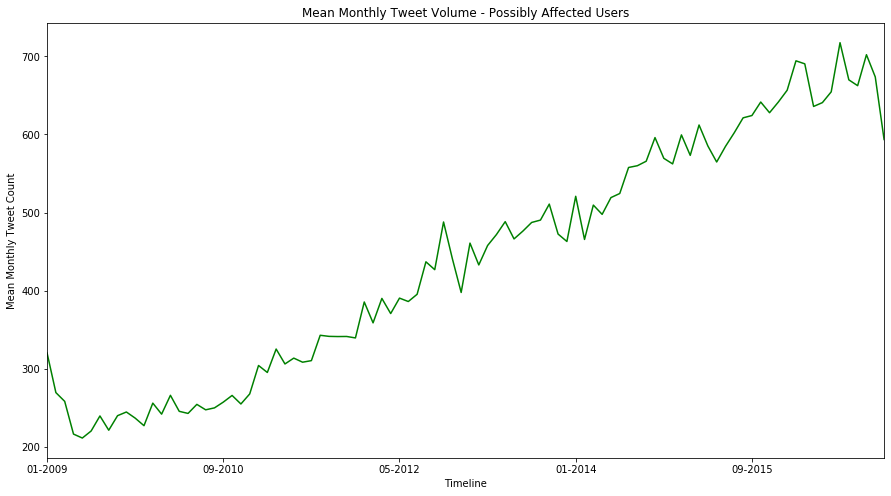

In [24]:
plt.figure()
tweet_countDF.mean().plot(kind='line', color='green', figsize=(15,8),title='Mean Monthly Tweet Volume - Possibly Affected Users')
# plt.legend(('Trump','Hillary'))
plt.ylabel('Mean Monthly Tweet Count')
plt.xlabel('Timeline')
plt.savefig('PAU_graphics/INF_pau_tweetcount.png')
plt.show()

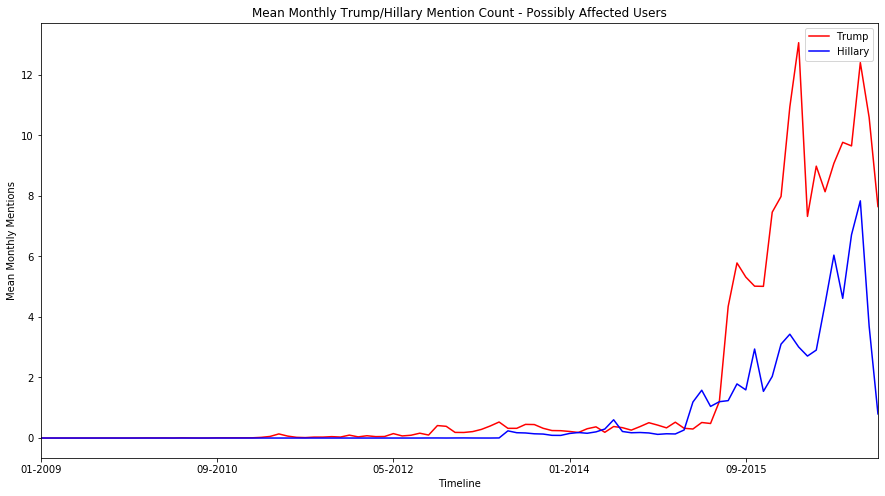

In [25]:
plt.figure()
trump_countDF.mean().plot(kind='line', color='red', figsize=(15,8),title='Mean Monthly Trump/Hillary Mention Count - Possibly Affected Users')
clinton_countDF.mean().plot(kind='line', color='blue', figsize=(15,8))
plt.legend(('Trump','Hillary'))
plt.ylabel('Mean Monthly Mentions')
plt.savefig('PAU_graphics/INF_pau_mentions.png')
plt.xlabel('Timeline')
plt.show()

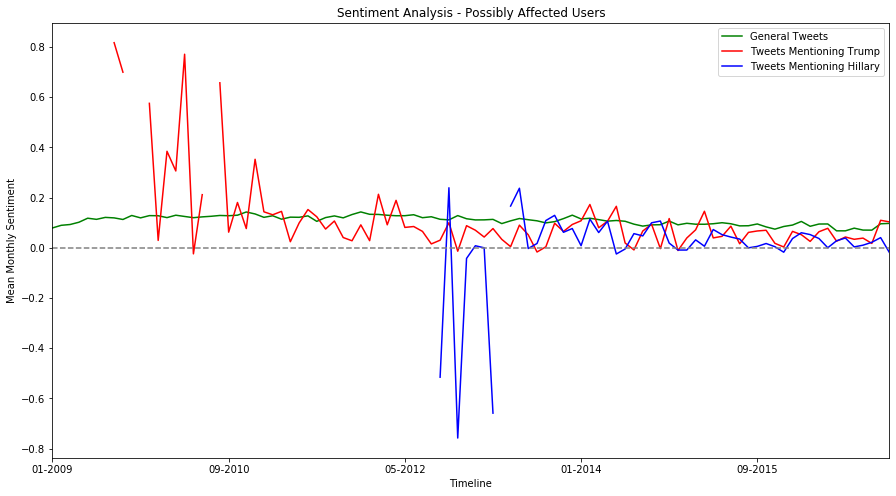

In [26]:
plt.figure()
sentiment_scoresDF.mean().plot(kind='line', color='green', figsize=(15,8),title='Sentiment Analysis - Possibly Affected Users')
trump_sentDF.mean().plot(kind='line', color='red', figsize=(15,8))
clinton_sentDF.mean().plot(kind='line', color='blue', figsize=(15,8))
plt.legend(('General Tweets','Tweets Mentioning Trump','Tweets Mentioning Hillary'))
plt.axhline(0, color="grey", linestyle="--")
plt.ylabel('Mean Monthly Sentiment')
plt.savefig('PAU_graphics/INF_pau_sentiment.png')
plt.xlabel('Timeline')
plt.show()